#########################################################################################################################################

# Attribute Standardization and Enrichment

#########################################################################################################################################

In [27]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re

In [28]:
df = pd.read_pickle(r'C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\clean_data1.pkl')

# 1. Geographical Validation and Standardization

## 1.1 Extract 'state' from 'address'

In [29]:
# Remove singapore and thailand data
df = df[~df["address"].str.contains("Singapore|Thailand|Indonesia")]

In [30]:
# Extract state from address using regex 
malaysia_states = [
    "Johor", "Kedah", "Kelantan", "Kuala Lumpur", "Perak", "Pahang", "Labuan",
    "Melaka", "Malacca","Negeri Sembilan", "Pulau Pinang", "Penang", "Pantai Batu Feringghi",
    "Kota Kinabalu", "Kudat", "Manukan Island", "Borneo", "Sipadan Island", "Sandakan", "Semporna", "Sabah",
    "Perlis", "Putrajaya", "Sarawak", "Selangor", "Terengganu"
]
regex_pattern = r'(' + '|'.join(malaysia_states) + r')'
df['state'] = df['address'].str.extract(regex_pattern, flags=re.IGNORECASE)


# Standardize State 
df['state'] = df['state'].str.title()
state_map = {
    "Malacca": "Melaka",
    "Pulau Pinang": "Penang",
    "Pantai Batu Feringghi": "Penang",
    "Kota Kinabalu": "Sabah",
    "Kudat": "Sabah",
    "Manukan Island": "Sabah",
    "Borneo": "Sabah",  
    "Sipadan Island": "Sabah",
    "Sandakan": "Sabah",
    "Semporna": "Sabah"
}
df['state'].replace(state_map, inplace=True)
df.drop(columns="region", inplace=True)

# Print outcome
df['state'].value_counts()

C:\Users\Ong Hui Ling\AppData\Local\Temp\ipykernel_18404\3767058577.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['state'].replace(state_map, inplace=True)


state
Kuala Lumpur       4300
Selangor           4140
Perak              3455
Johor              3010
Penang             2875
Pahang             2870
Sabah              2705
Kedah              2540
Negeri Sembilan    2170
Melaka             2120
Sarawak            1895
Terengganu         1315
Kelantan           1150
Putrajaya           990
Perlis              485
Labuan              270
Name: count, dtype: int64

In [31]:
# Check for null value
print("Total null value for state:",df['state'].isnull().sum())

null_state = df[df['state'].isnull()]
null_state['name']

Total null value for state: 10


8555            Taman Negeri Perlis
8556            Taman Negeri Perlis
8557            Taman Negeri Perlis
8558            Taman Negeri Perlis
8559            Taman Negeri Perlis
9760    Sipadan Kapalai Dive Resort
9761    Sipadan Kapalai Dive Resort
9762    Sipadan Kapalai Dive Resort
9763    Sipadan Kapalai Dive Resort
9764    Sipadan Kapalai Dive Resort
Name: name, dtype: object

In [32]:
# handle special case
df['state'] = np.where(
    (df['state'].isnull()) & (df["name"] == "Taman Negeri Perlis"),  
    "Perlis",                 
    df['state']       
)

df['state'] = np.where(
    (df['state'].isnull()) & (df["name"] == "Sipadan Kapalai Dive Resort"),  
    "Sabah",                 
    df['state']       
)

print("Total null value for state:",df['state'].isnull().sum())

Total null value for state: 0


# 2. Operating Hours Standardization

## 2.1 Check for null value

In [33]:
# check null count
df.isnull().sum()

place_id                    0
name                        0
address                     0
latitude                    0
longitude                   0
types                       0
googleMapsUri               0
priceRange              22315
place_overall_rating        0
userRatingCount             0
operating_hours          4095
extract_date                0
author_name                 0
user_review_rating          0
text                        0
author_id                   0
uniqueID                    0
timestamp                   0
main_category               0
sub_category                0
state                       0
dtype: int64

In [34]:
null_df = df[df['operating_hours'].isnull()]
null_df['main_category'].value_counts()

main_category
hotel                 2690
tourist_attraction    1205
restaurant             140
mall                    60
Name: count, dtype: int64

**Findings:**
- We will fill the null value for operating_hours using mode for each category/ sub-category

## 2.2 Cleaning for operating_hours column

In [35]:
def clean_operating_hours(df, column_name='operating_hours'):
    """
    Cleans a messy operating hours column and extracts useful features.

    This function does the following:
    1. Fills NaN values with 'Not Available'.
    2. Fixes common text encoding errors ('â€¯', 'â€‰', 'â€“').
    3. Normalizes 'Open 24 hours' to '24 Hours'.
    4. Replaces newlines with ' | ' for easier parsing.
    5. Extract hours for all seven days.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column.
        column_name (str): The name of the messy operating hours column.

    Returns:
        pd.DataFrame: A DataFrame with the new, clean columns.
    """
    # Create a copy to avoid modifying the original DataFrame unexpectedly
    df_clean = df.copy()

    # --- 1. Handle NaN values ---
    # Fill NaN values first so all subsequent .str methods work
    df_clean[column_name] = df_clean[column_name].fillna('Not Available')

    # --- 2. Fix encoding errors and normalize text ---
    # Replace weird space/hyphen characters:
    # â€¯ and â€‰ are types of spaces (replace with nothing)
    # â€“ is an en-dash (replace with a standard hyphen '-')
    clean_col = df_clean[column_name].astype(str)
    clean_col = clean_col.str.replace('â€¯', '', regex=False)
    clean_col = clean_col.str.replace('â€‰', '', regex=False)
    clean_col = clean_col.str.replace('â€“', '-', regex=False)
    clean_col = clean_col.str.replace('Ã¢â‚¬Â¯', '', regex=False) 
    clean_col = clean_col.str.replace('Ã¢â‚¬â€°', '', regex=False) 
    clean_col = clean_col.str.replace('Ã¢â‚¬â€œ', '-', regex=False) 

    # Normalize 'Open 24 hours' for easier matching
    clean_col = clean_col.str.replace('Open 24 hours', '24 Hours', regex=False)
    
    # Replace newlines with a clear delimiter for parsing
    # This turns the multi-line string into one long line
    clean_col = clean_col.str.replace('\n', ' | ', regex=False)
    df_clean['operating_hours_cleaned'] = clean_col

    #--- 3. Extract hours for all seven days ---
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for day in days_of_week:
        # Create the regex pattern for the current day
        # e.g., r'Monday: \s*(.*?)(?: \| |$)'
        # This looks for the day, captures the text, and stops at the next '|' or end of string
        pattern = rf'{day}: \s*(.*?)(?: \| |$)'
        
        # .str.extract(pattern) returns a DataFrame with the captured group
        # We use flags=re.IGNORECASE to match "Monday" or "monday"
        extracted_hours = clean_col.str.extract(pattern, flags=re.IGNORECASE)
        
        # Create the new column name, e.g., 'Monday_hours'
        new_column_name = f'{day}_hours'
        
        # Clean up the extracted data:
        # - .squeeze('columns') converts the DataFrame to a Series
        # - .str.strip() removes any leading/trailing whitespace
        # - .fillna() replaces any non-matches (like 'Not Available')
        df_clean[new_column_name] = extracted_hours.squeeze('columns') \
                                                .str.strip() \
                                                .fillna('Not Available')

    return df_clean

In [36]:
# Run the cleaning function
df_cleaned = clean_operating_hours(df, 'operating_hours')
df_cleaned.drop(columns=['operating_hours'], inplace=True)

## 2.3 Standardize operating hours (1.00-10.00PM) to (1.00PM-10.00PM)

In [37]:
df_cleaned['Monday_hours'].unique()

array(['24 Hours', '5:00AM-9:30PM', 'Not Available', '10:00AM-10:00PM',
       '10:00AM-6:00PM', '4:00AM-10:00PM', '12:00-9:00PM',
       '9:00AM-6:00PM', '11:00AM-12:00AM', '5:00-11:00PM',
       '6:00AM-8:00PM', '8:00AM-5:00PM', '8:00AM-12:00AM',
       '9:00AM-5:00PM', '7:00AM-6:00PM', '9:30AM-5:30PM', '6:00AM-7:00PM',
       '6:00AM-10:00PM', 'Closed', '5:30PM-12:00AM', '5:00AM-10:00PM',
       '8:00AM-8:00PM', '11:00AM-11:00PM', '11:00AM-7:00PM',
       '10:00AM-7:00PM', '9:00AM-10:00PM', '6:30AM-7:00PM',
       '7:30-10:00PM', '9:00AM-8:00PM', '6:00AM-11:00PM',
       '11:00AM-9:00PM', '10:00AM-8:00PM', '6:15AM-7:30PM',
       '10:00AM-9:30PM', '10:00AM-12:00AM', '7:00AM-6:30PM',
       '12:00-3:00PM, 6:00-11:00PM', '11:00AM-10:30PM', '6:30AM-10:00PM',
       '7:00AM-7:00PM', '9:30AM-5:00PM', '11:00AM-6:00PM',
       '5:00AM-1:00AM', '8:00AM-10:00PM', '9:00AM-12:00AM',
       '6:00AM-12:00AM', '9:00AM-1:00PM', '10:00AM-3:30PM',
       '10:30AM-9:30PM', '7:30AM-2:00PM', '5:00AM-7:

In [38]:
def final_fix_am_pm(time_str):
    
    # Eg: 6:00-4:00AM
    # Groups: 
    # (1: 6:00)            - time1
    # (2:  - 4:00 AM)      - rest_of_string
    # (3: 4)               - hour2
    # (4: AM)              - end_am_pm
    pattern = r'(\d{1,2}:\d{2})(?!\s*[AP]M)(\s*-\s*(\d{1,2}):\d{2}\s*([AP]M))'
    
    # This is an "inner" function that re.sub will call for every match
    def replacer(match):
        time_part = match.group(1)      # e.g., "6:00"
        rest_of_string = match.group(2) # e.g., " - 4:00 AM"
        end_am_pm = match.group(4)      # e.g., "AM"
        
        try:
            hour1 = int(time_part.split(':')[0])
            hour2 = int(match.group(3))
        except ValueError:
            return match.group(0) # On error, just return the original string
  
        prefix = "" 
        
        if hour1 in [12, 1, 2, 3, 4]:
            prefix = "PM"
        elif hour1 in [8, 9, 10, 11]:
            prefix = "AM"
        elif hour1 in [5, 6, 7]:           
            # Handle the 12 o'clock wrap-around for comparison
            # e.g., 10:00 - 12:00 AM (10pm-12am) -> hour1=10, hour2=12. 10 < 12.
            # We treat 12 as a "high" number
            
            # If 12 AM/PM, it's always "greater" than 5, 6, 7
            if hour2 == 12:
                # e.g. 6:00 - 12:00 PM -> 6:00AM - 12:00PM
                prefix = "PM" if end_am_pm == "AM" else "AM"
            
            elif hour1 > hour2:
                # OVERNIGHT: 6:00 - 4:00 AM -> hour1=6, hour2=4
                # Fill with OPPOSITE
                prefix = "PM" if end_am_pm == "AM" else "AM"
            else:
                # (hour1 < hour2)
                # DAY SHIFT: 6:00 - 10:00 AM -> hour1=6, hour2=10
                # Fill with SAME
                prefix = f"{end_am_pm}"
        else:
            # Should not be hit, but return original just in case
            return match.group(0)
        
        # Rebuild the string (with no space, as you requested)
        return time_part + prefix + rest_of_string

    # Run the substitution on the input string.
    return re.sub(pattern, replacer, str(time_str))

In [39]:
day_columns = [
    'Monday_hours', 
    'Tuesday_hours', 
    'Wednesday_hours', 
    'Thursday_hours', 
    'Friday_hours', 
    'Saturday_hours', 
    'Sunday_hours'
]

for col in day_columns:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].apply(final_fix_am_pm)

# 3. Operating Hours Missing Values Handling

## 3.1 Operating Hours Analysis by Category

In [40]:
def get_clean_value_counts(series):
    """
    Cleans a series and returns its value_counts(),
    ignoring 'Not Available' and 'Closed'.
    """
    cleaned_series = series[
        ~series.isin(['Not Available', 'Closed', ''])
    ].copy()
    
    return cleaned_series.value_counts()

In [41]:
# Shows the Top 3 most common operating hours (modes) for specific restaurant, mall and hotel, excluding 'Not Available' and 'Closed'.
categories_to_check = ['restaurant', 'mall', 'hotel']
days = ['Monday_hours', 'Tuesday_hours', 'Wednesday_hours', 'Thursday_hours', 'Friday_hours', 'Saturday_hours', 'Sunday_hours']
for cat in categories_to_check:
    print(f"\n--- Top 3 for Category: '{cat}' ---")
    for day in days:
        # Filter the DataFrame for this sub-category
        df_filtered = df_cleaned[df_cleaned['main_category'] == cat]
        
        # Get the clean value counts
        value_counts = get_clean_value_counts(df_filtered[day])
        
        print(f"Top 3 '{day}':")
        if value_counts.empty:
            print("  No valid operating hours found.")
        else:
            print(value_counts.head(3))


--- Top 3 for Category: 'restaurant' ---
Top 3 'Monday_hours':
Monday_hours
24 Hours           1130
10:00AM-10:00PM     955
11:00AM-10:00PM     785
Name: count, dtype: int64
Top 3 'Tuesday_hours':
Tuesday_hours
24 Hours           1140
10:00AM-10:00PM     985
11:00AM-10:00PM     785
Name: count, dtype: int64
Top 3 'Wednesday_hours':
Wednesday_hours
24 Hours           1125
10:00AM-10:00PM     975
11:00AM-10:00PM     790
Name: count, dtype: int64
Top 3 'Thursday_hours':
Thursday_hours
24 Hours           1135
10:00AM-10:00PM     975
11:00AM-10:00PM     795
Name: count, dtype: int64
Top 3 'Friday_hours':
Friday_hours
24 Hours           1125
10:00AM-10:00PM     910
11:00AM-10:00PM     740
Name: count, dtype: int64
Top 3 'Saturday_hours':
Saturday_hours
24 Hours           1130
10:00AM-10:00PM     950
11:00AM-10:00PM     780
Name: count, dtype: int64
Top 3 'Sunday_hours':
Sunday_hours
24 Hours           1130
10:00AM-10:00PM     965
11:00AM-10:00PM     800
Name: count, dtype: int64

--- Top 3 

In [42]:
df_tourist = df_cleaned[df_cleaned['main_category']=='tourist_attraction']
df_tourist['sub_category'].value_counts()

sub_category
park_nature                   2240
tourist_attraction_general    1995
religious                     1365
museum_gallery                 645
amusement                      630
other                          355
landmark                         5
Name: count, dtype: int64

**Decision**:
- Fill mode (top 1) for category hotel and mall since top 1 is much higher than 2th and 3rd count
- Fill second highest value for category restaurant

In [43]:
categories_to_check = ['park_nature', 'tourist_attraction_general', 'religious', 'museum_gallery', 'amusement', 'other', 'landmark']
days = ['Monday_hours', 'Tuesday_hours', 'Wednesday_hours', 'Thursday_hours', 'Friday_hours', 'Saturday_hours', 'Sunday_hours']
for cat in categories_to_check:
    print(f"\n--- Top 3 for Category: '{cat}' ---")
    for day in days:
        # Filter the DataFrame for this sub-category
        df_filtered = df_tourist[df_tourist['sub_category'] == cat]
        
        # Get the clean value counts
        value_counts = get_clean_value_counts(df_filtered[day])
        
        print(f"Top 3 '{day}':")
        if value_counts.empty:
            print("  No valid operating hours found.")
        else:
            print(value_counts.head(3))


--- Top 3 for Category: 'park_nature' ---
Top 3 'Monday_hours':
Monday_hours
24 Hours         535
7:00AM-7:00PM    110
8:00AM-5:00PM     90
Name: count, dtype: int64
Top 3 'Tuesday_hours':
Tuesday_hours
24 Hours         530
7:00AM-7:00PM    115
8:00AM-5:00PM     85
Name: count, dtype: int64
Top 3 'Wednesday_hours':
Wednesday_hours
24 Hours         530
7:00AM-7:00PM    115
8:00AM-5:00PM     90
Name: count, dtype: int64
Top 3 'Thursday_hours':
Thursday_hours
24 Hours         535
7:00AM-7:00PM    115
8:00AM-5:00PM     95
Name: count, dtype: int64
Top 3 'Friday_hours':
Friday_hours
24 Hours         530
7:00AM-7:00PM    115
8:00AM-5:00PM     90
Name: count, dtype: int64
Top 3 'Saturday_hours':
Saturday_hours
24 Hours         535
7:00AM-7:00PM    105
8:00AM-5:00PM     90
Name: count, dtype: int64
Top 3 'Sunday_hours':
Sunday_hours
24 Hours         540
7:00AM-7:00PM    110
8:00AM-5:00PM     90
Name: count, dtype: int64

--- Top 3 for Category: 'tourist_attraction_general' ---
Top 3 'Monday_h

**Decision**:
- For tourist attraction, fill na with mode of each subcategory since different sub-category would have different operating hours. 
- For amusement, Tuesday_hours fill na with second mode (10pm to 6pm), second and first only 1 count different

**Final Decision**:
- Instead of hardcoding, we will go for calculating the overall mode for each category (aggregate all seven days data) and fill na with that value

##  3.2 Fill null value with mode
- Fill NA with mode of each main category (restaurant, hotel, mall) and mode fo eact sub-category for tourist attraction

In [44]:
def get_mode_for_filling(series):
    """
    Helper function: Calculates the Top 1 mode (most frequent),
    ignoring non-useful values.
    """
    cleaned_series = series[
        ~series.isin(['Not Available', 'Closed', '', pd.NA, np.nan])
    ]
    if cleaned_series.empty:
        return np.nan
    else:
        return cleaned_series.mode().iloc[0]

In [45]:
def get_second_mode_for_filling(series):
    """
    Helper function: Calculates the Top 2 mode (second most frequent),
    ignoring non-useful values.
    Falls back to Top 1 if no 2nd mode exists.
    """
    cleaned_series = series[
        ~series.isin(['Not Available', 'Closed', '', pd.NA, np.nan])
    ]
    if cleaned_series.empty:
        return np.nan
    
    value_counts = cleaned_series.value_counts()
    
    if len(value_counts) >= 2:
        return value_counts.index[1] # Return 2nd mode
    elif len(value_counts) == 1:
        return value_counts.index[0] # Fallback to 1st mode
    else:
        return np.nan

In [46]:
def fill_missing_hours_hybrid(df_cleaned):
    """
    Fills 'Not Available' operating hours.
    
    Calculates ONE "overall mode" for each category
    by looking at all 7 days at once, then applies it.
    This is more robust to daily outliers.
    
    - 'tourist_attraction': Fills by SUB-category mode (Top 1)
    - 'restaurant': Fills by MAIN-category mode (Top 2)
    - 'mall', 'hotel': Fills by MAIN-category mode (Top 1)
    
    Returns:
        pd.DataFrame: A new DataFrame with hours filled in.
    """
    
    print("Filling missing hours with 'overall mode' hybrid logic...")
    df_filled = df_cleaned.copy()
    
    days_to_fill = [
        'Monday_hours', 'Tuesday_hours', 'Wednesday_hours', 
        'Thursday_hours', 'Friday_hours', 'Saturday_hours', 'Sunday_hours'
    ]

    # --- CALCULATE OVERALL MODES FIRST ---
    
    # --- 1. 'tourist_attraction' OVERALL modes (by sub-category) ---
    print("  Calculating 'tourist_attraction' sub-category overall modes...")
    df_ta = df_filled[df_filled['main_category'] == 'tourist_attraction']
    
    # We .stack() all 7 day columns into one Series per group, 
    # then get the mode of that.
    # We use .apply() on the groupby object with a lambda function.
    ta_sub_cat_modes = df_ta.groupby('sub_category')[days_to_fill].apply(
        lambda x: get_mode_for_filling(x.stack())
    )
    # This creates a Series:
    # sub_category
    #   museum_gallery    9AM-5PM
    #   park_nature       24 Hours
    
    # --- 2. 'mall', 'hotel', 'restaurant' OVERALL modes (by main-category) ---
    print("  Calculating 'restaurant', 'mall', 'hotel' main-category overall modes...")
    main_cat_modes = {}
    
    # Top 1 for 'mall'
    mall_series = df_filled[df_filled['main_category'] == 'mall'][days_to_fill].stack()
    main_cat_modes['mall'] = get_mode_for_filling(mall_series)
            
    # Top 1 for 'hotel'
    hotel_series = df_filled[df_filled['main_category'] == 'hotel'][days_to_fill].stack()
    main_cat_modes['hotel'] = get_mode_for_filling(hotel_series)
            
    # Top 2 for 'restaurant'
    restaurant_series = df_filled[df_filled['main_category'] == 'restaurant'][days_to_fill].stack()
    main_cat_modes['restaurant'] = get_second_mode_for_filling(restaurant_series)
    
    print(f"    -> Overall Main Modes found: {main_cat_modes}")
    print(f"    -> Overall TA-Sub Modes found:\n{ta_sub_cat_modes.head()}")

    # --- 3. CREATE FINAL FILL MAP ---
    
    # Map main-category modes (for mall, hotel, restaurant)
    main_cat_fill_map = df_filled['main_category'].map(main_cat_modes)
    
    # Map sub-category modes (for tourist_attraction)
    sub_cat_fill_map = df_filled['sub_category'].map(ta_sub_cat_modes)
    
    # Combine the maps.
    # This takes the TA sub-category map, and for any row that isn't a TA,
    # it fills the value in from the main-category map.
    final_fill_map = sub_cat_fill_map.combine_first(main_cat_fill_map)

    # --- 4. LOOP AND FILL ---
    print("\n  Looping through days to fill NaNs with overall modes...")
    for day in days_to_fill:
        print(f"    Processing: {day}")
        
        # 1. Replace 'Not Available' with np.nan for filling
        df_filled[day] = df_filled[day].replace('Not Available', np.nan)
        
        # 2. Fill NaNs using our combined, overall-mode map
        df_filled[day] = df_filled[day].fillna(final_fill_map)

        # 3. Fill any remaining nans back to 'Not Available'
        df_filled[day] = df_filled[day].fillna('Not Available')
        
    print("\nFinished filling hours.")
    return df_filled

In [47]:
df_cleaned = fill_missing_hours_hybrid(df_cleaned)

Filling missing hours with 'overall mode' hybrid logic...
  Calculating 'tourist_attraction' sub-category overall modes...
  Calculating 'restaurant', 'mall', 'hotel' main-category overall modes...
    -> Overall Main Modes found: {'mall': '10:00AM-10:00PM', 'hotel': '24 Hours', 'restaurant': '10:00AM-10:00PM'}
    -> Overall TA-Sub Modes found:
sub_category
amusement         10:00AM-6:00PM
landmark                24 Hours
museum_gallery     9:00AM-5:00PM
other                   24 Hours
park_nature             24 Hours
dtype: object

  Looping through days to fill NaNs with overall modes...
    Processing: Monday_hours
    Processing: Tuesday_hours
    Processing: Wednesday_hours
    Processing: Thursday_hours
    Processing: Friday_hours
    Processing: Saturday_hours
    Processing: Sunday_hours

Finished filling hours.


# 4. Restaurant Name Cleaning

In [48]:
def clean_name_multilingual(text):
    if not isinstance(text, str) or not text.strip():
        return None
    try:
        # Try double decoding to fix heavily corrupted mojibake
        text = text.encode('latin1').decode('utf-8', errors='ignore')
        text = text.encode('latin1').decode('utf-8', errors='ignore')
    except Exception:
        pass
    
    # Keep English, Chinese, Japanese, Korean, and basic punctuation
    text = re.sub(r'[^A-Za-z0-9\u4E00-\u9FFF\u3040-\u30FF\uAC00-\uD7AF\s\-\.,&\'|]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else None

In [49]:
df_cleaned['clean_name'] = df_cleaned['name'].apply(clean_name_multilingual)

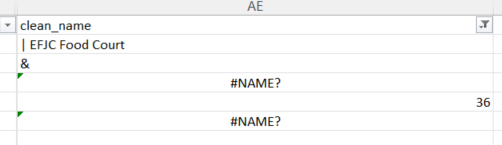

Manual convert certain chinese restaurants name 
based on clean_name column
1. & -> Puning Hotpot & BBQ
2. 36 -> Kampar 36 Hawker Centre

based on the place_id
1. Ã¥ÂÂÃ¥â€¦Â¨Ã¥ÂÂÃ§Â¾Å½Ã§Â¾Å½Ã©Â£Å¸Ã¤Â¸Â­Ã¥Â¿Æ’ -> Medan Selera Seeme Food Court (ChIJu0mhlM00zDERdSIdZbIU91M)
2. Ã¦â‚¬Â¡Ã¤Â¿ÂÃ¥Â¤Â§Ã¦Â â€˜Ã¥Â¤Â´Ã§Â¾Å½Ã©Â£Å¸Ã¤Â¸Â­Ã¥Â¿Æ’ -> Ipoh by the Tree Food Court (ChIJ3YMFT2zsyjER_A8O_WygT5w)
3. Ã¨Â¯Å¡Ã¤Â¿Â¡Ã¨Å Â±Ã¥â€ºÂ­Ã¥â€™â€“Ã¥â€“Â±Ã©Â±Â¼Ã¥Â¤Â´ -> Hainan Orkid Tropica Cafe (ChIJny8gcCpbSzARcOcn7UyRAP8)
4. Restoran Paradise Seremban (ChIJMbRovmHozTERkYnW4D6Hong)
5. Chan Kou Xian Hotpot -Kuching (ChIJ1bzbsXWn-zER0kRnhjc6A28)

In [50]:
# Handle special case
df_cleaned['clean_name'] = df_cleaned['clean_name'].replace({
    '&': 'Puning Hotpot & BBQ',
    '36': 'Kampar 36 Hawker Centre',
})

df_cleaned['clean_name'] = (
    df_cleaned['clean_name']
    .str.replace(r'\|', '', regex=True)        # remove pipe symbol
    .str.strip()                               # trim whitespace
)

In [51]:
# handle special case
df_cleaned.loc[df_cleaned['place_id'] == "ChIJu0mhlM00zDERdSIdZbIU91M", 'clean_name'] = "Medan Selera Seeme Food Court"
df_cleaned.loc[df_cleaned['place_id'] == "ChIJ3YMFT2zsyjER_A8O_WygT5w", 'clean_name'] = "Ipoh Big Tree Food Court"
df_cleaned.loc[df_cleaned['place_id'] == "ChIJny8gcCpbSzARcOcn7UyRAP8", 'clean_name'] = "Hainan Orkid Tropica Cafe"
df_cleaned.loc[df_cleaned['place_id'] == "ChIJMbRovmHozTERkYnW4D6HOng", 'clean_name'] = "Restoran Paradise Seremban"
df_cleaned.loc[df_cleaned['place_id'] == "ChIJ1bzbsXWn-zER0kRnhjc6A28", 'clean_name'] = "Chan Kou Xian Hotpot - Kuching"
df_cleaned.loc[df_cleaned['place_id'] == "ChIJr3mHEVFDSzAR_DxKcK9SJdM", 'clean_name'] = "Mergong Dede Moda Restaurant"


In [52]:
df_cleaned.to_csv(r'C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\clean_data2.csv')
df_cleaned.to_pickle(r'C:\Users\Ong Hui Ling\Dropbox\PC\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\clean_data2.pkl')